# Trans-dimensional inference with JAXNS
This is a problem where the number of parameters is not fixed, and we want to infer the posterior distribution over the parameters.

For our problem we will use a polynomical of unknown degree to fit a set of data points.

In [1]:

import os

import jax.random

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"
from jax import config

config.update("jax_enable_x64", True)

import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import NestedSampler
from jaxns import Model
from jaxns import Prior
from jaxns import bruteforce_evidence

tfpd = tfp.distributions

INFO:2025-06-02 02:27:46,956:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


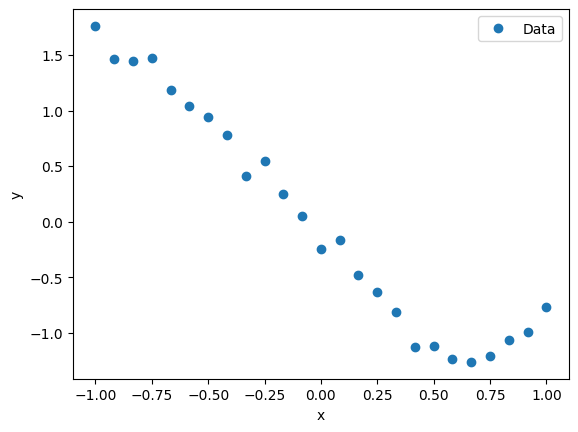

In [20]:
x = jnp.linspace(-1, 1, 25)
N_true = 5
alpha = jax.random.normal(random.PRNGKey(42), shape=(N_true + 1,))
y = jnp.polyval(alpha[::-1], x) + 0.1 * jax.random.normal(random.PRNGKey(43), shape=x.shape)

plt.plot(x, y, 'o', label='Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [21]:
from jax._src.scipy.special import logsumexp
from jaxns.framework.special_priors import Categorical

N_max = 10  # Maximum number of polynomial coefficients

def log_likelihood(alpha):
    mean = jnp.polyval(alpha[::-1], x)
    dist = tfpd.Normal(mean, scale=0.1)
    return dist.log_prob(y).sum()


def prior_model():
    n = yield Categorical(parametrisation='cdf', logits=jnp.ones(N_max), name='n')
    alpha = yield Prior(tfpd.Normal(loc=jnp.zeros(N_max+1), scale=1.0), name='alpha')
    alpha = jnp.where(jnp.arange(N_max+1) < n+1, alpha, 0.0)
    return alpha


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)



In [22]:


# Create the nested sampler class. In this case without any tuning.
ns = NestedSampler(model=model, difficult_model=True)

termination_reason, state = ns(random.PRNGKey(42))
results = ns.to_results(termination_reason=termination_reason, state=state)


Running over 6 devices.


In [23]:
# We can use the summary utility to display results
ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 15656781
samples: 27600
phantom samples: 0
likelihood evals / sample: 567.3
phantom fraction (%): 0.0%
--------
logZ=7.98 +- 0.14
max(logL)=27.79
H=-15.85
ESS=2696
--------
alpha[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
alpha[0]: -0.129 +- 0.039 | -0.178 / -0.129 / -0.081 | -0.132 | -0.119
alpha[1]: -2.24 +- 0.11 | -2.38 / -2.26 / -2.09 | -2.23 | -2.12
alpha[2]: -0.02 +- 0.25 | -0.33 / -0.02 / 0.3 | 0.03 | -0.24
alpha[3]: 0.88 +- 0.39 | 0.27 / 0.98 / 1.21 | 0.37 | -0.18
alpha[4]: 0.63 +- 0.38 | 0.22 / 0.63 / 1.04 | 0.45 | 1.16
alpha[5]: 0.26 +- 0.88 | -0.87 / 0.3 / 1.29 | 0.97 | 1.55
alpha[6]: 0.14 +- 0.88 | -1.03 / 0.19 / 1.19 | 0.11 | -0.2
alpha[7]: 0.11 +- 0.99 | -1.29 / 0.16 / 1.32 | 0.37 | 0.84
alpha[8]: -0.15 +- 0.96 | -1.31 / -0.27 / 1.16 | 0.02 | -0.15
alpha[9]: 0.0 +- 1.0 | -1.3 / 0.1 / 1.3 | -0.7 | -1.4
alpha[10]: -0.1 +- 0.96 | -1.28 / -0.14 / 1.13 | -0.55 | 0

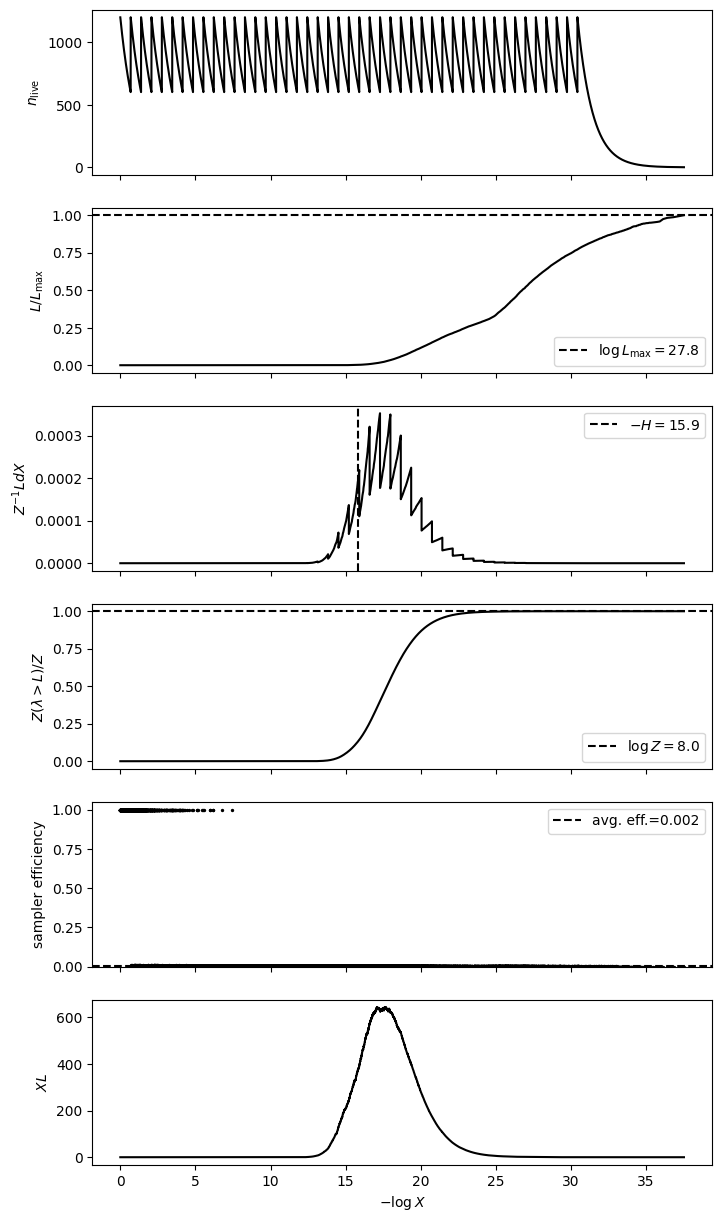

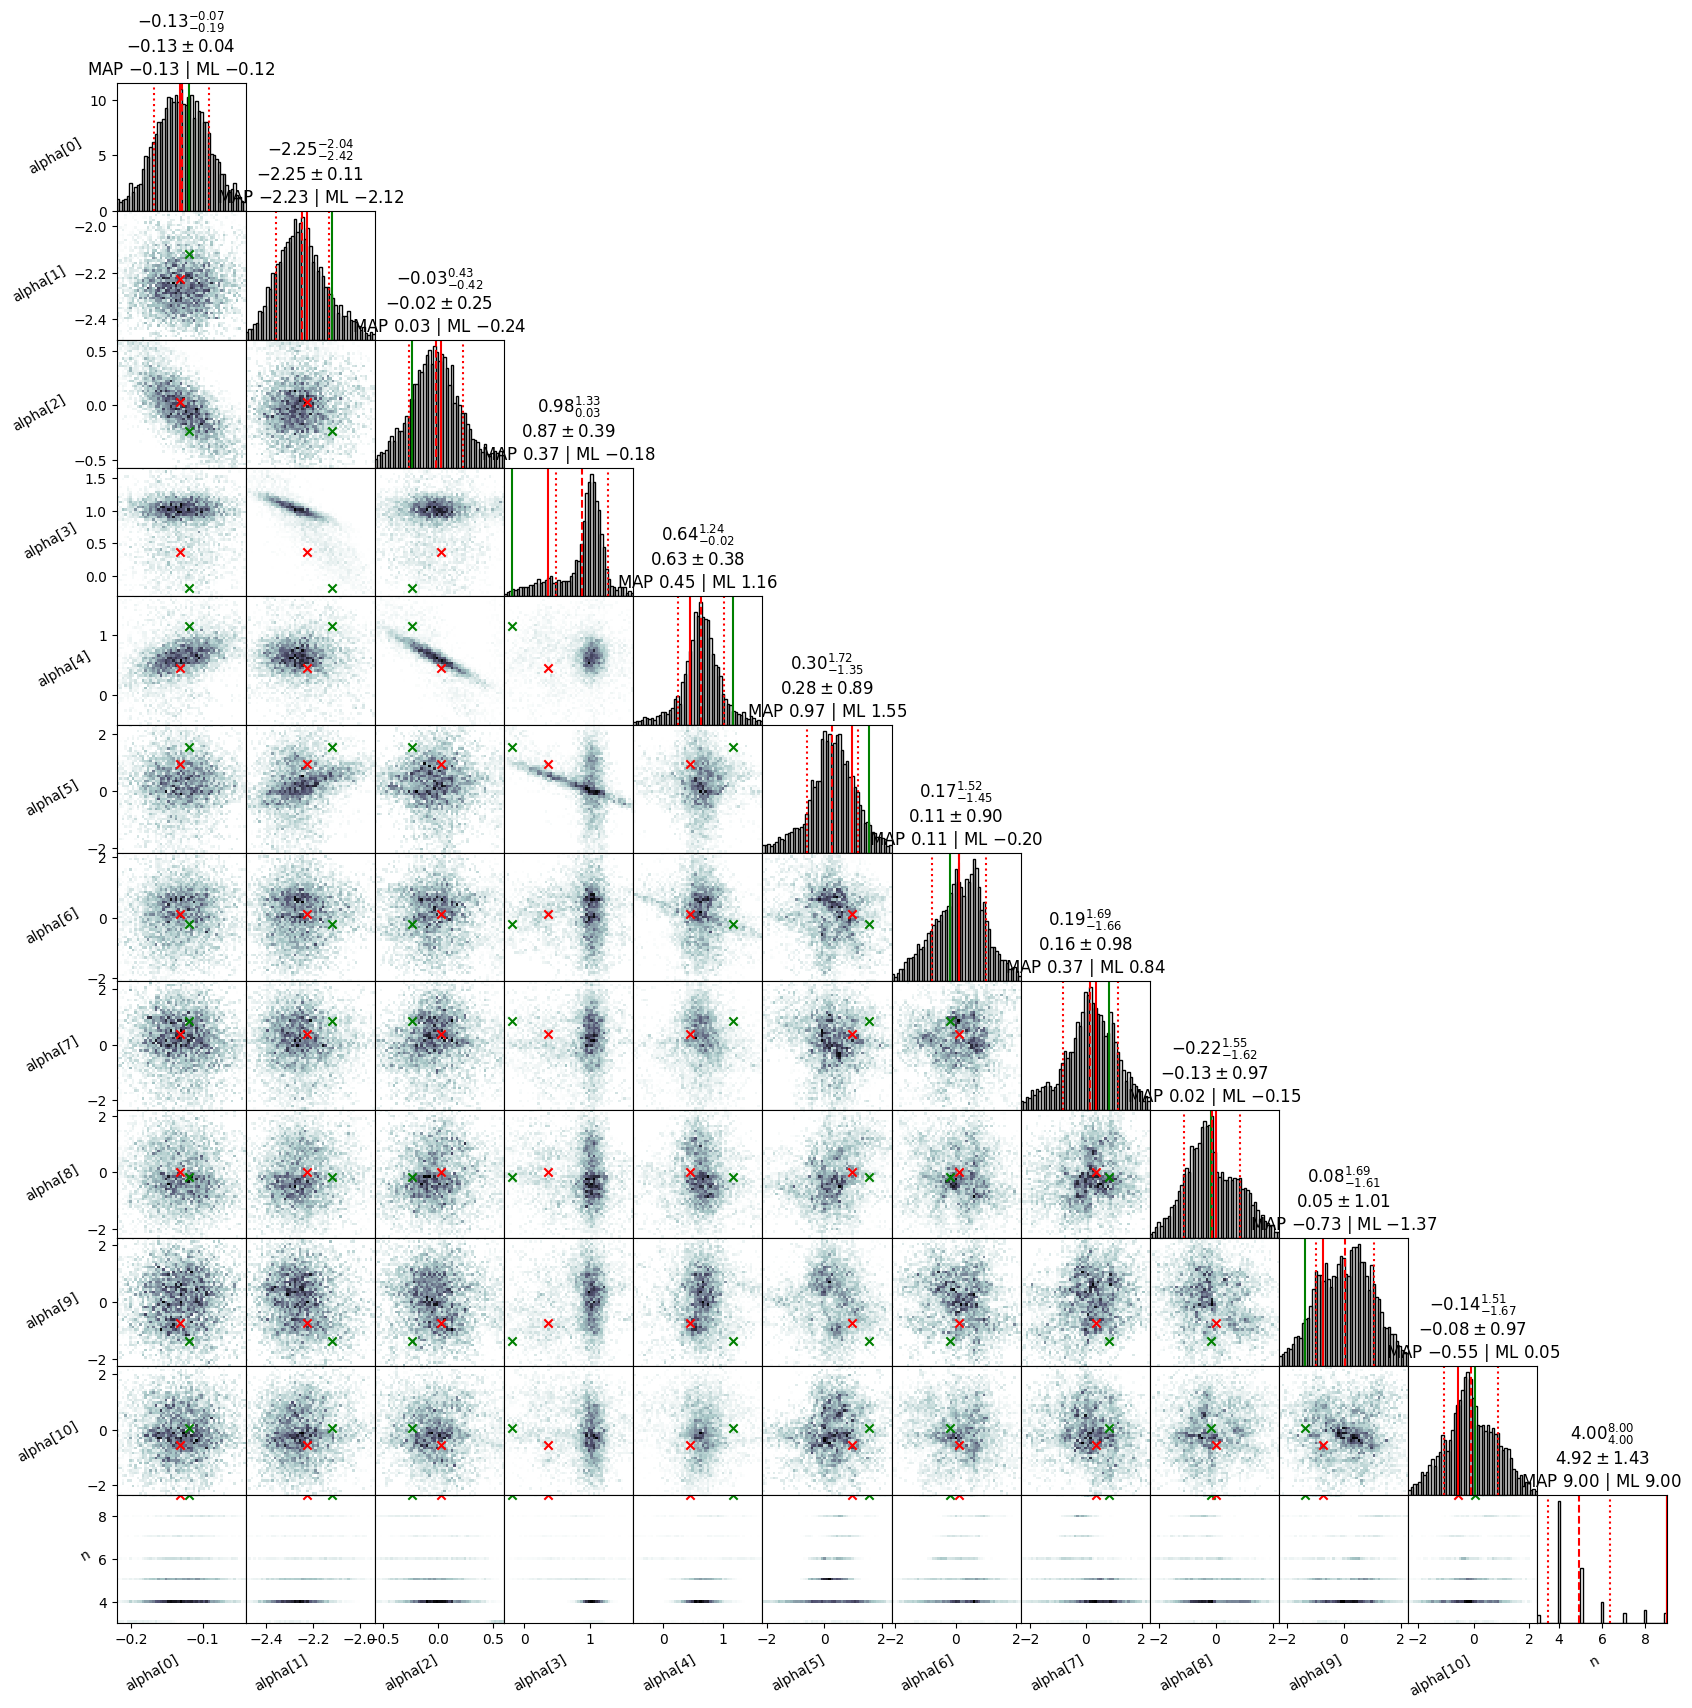

In [24]:
# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)